In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [33]:
df = pd.read_csv('industrial_fault_detection_data_1000.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         1000 non-null   object 
 1   Vibration (mm/s)  1000 non-null   float64
 2   Temperature (°C)  1000 non-null   float64
 3   Pressure (bar)    1000 non-null   float64
 4   RMS Vibration     1000 non-null   float64
 5   Mean Temp         1000 non-null   float64
 6   Fault Label       1000 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 54.8+ KB


In [34]:
df.columns = [
    "timestamp",
    "vibration_mm_s",
    "temperature_c",
    "pressure_bar",
    "rms_vibration",
    "mean_temperature",
    "fault_label"
]

In [35]:
df.head()

,timestamp,vibration_mm_s,temperature_c,pressure_bar,rms_vibration,mean_temperature,fault_label
0,2023-03-10 00:00:00,0.437086,64.810634,7.785117,0.601657,90.561384,1
1,2023-03-10 00:01:00,0.955643,93.352076,7.740936,0.601657,90.561384,1
2,2023-03-10 00:02:00,0.758795,119.835667,9.718764,0.601657,90.561384,0
3,2023-03-10 00:03:00,0.638793,108.577991,7.748639,0.601657,90.561384,1
4,2023-03-10 00:04:00,0.240417,114.524892,7.815849,0.601657,90.561384,0


In [36]:
print("Veri Seti Boyutu: ", df.shape)
print("Eksik Veri Sayisi: ", df.isnull().sum())

Veri Seti Boyutu:  (1000, 7)
Eksik Veri Sayisi:  timestamp           0
vibration_mm_s      0
temperature_c       0
pressure_bar        0
rms_vibration       0
mean_temperature    0
fault_label         0
dtype: int64


In [37]:
df.describe()

,vibration_mm_s,temperature_c,pressure_bar,rms_vibration,mean_temperature,fault_label
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,0.541231,90.561384,8.507217,6.016565e-01,9.056138e+01,0.479000
std,0.262924,23.375191,0.872023,1.110779e-14,7.108983e-13,0.652675
min,0.104169,50.257461,7.000035,6.016565e-01,9.056138e+01,0.000000
25%,0.312376,69.285942,7.784053,6.016565e-01,9.056138e+01,0.000000
50%,0.547127,91.498713,8.501842,6.016565e-01,9.056138e+01,0.000000
75%,0.769888,110.837205,9.277311,6.016565e-01,9.056138e+01,1.000000
max,0.999746,129.953098,9.993463,6.016565e-01,9.056138e+01,2.000000


In [38]:
df['fault_label'].value_counts()

fault_label
0    609
1    303
2     88
Name: count, dtype: int64

In [39]:
# Etiketleri Binary Yap.
# 0 ise 0 olarak birakiyor, 1 veya 2 ise 1 yapiyor.
# df['fault_label'] = df['fault_label'].apply(lambda x: 0 if x == 0 else 1)

In [40]:
output_data = []
for col in df.columns: # Tum sutunlari inceliyor.

    if df.loc[:, col].nunique() <= 5: 
        """ Eger o sutunda en fazla 5 farkli deger varsa o zaman o sutunun tam olarak hangi degerleri aldgini
            listelemeye karar veriyor. 
            Mesela Fault Label sadece 2 farkli deger aliyor (0 ve 1), ama Temperature binlerce farkli deger aliyor. """
        
        unique_values = df.loc[:, col].unique()
        """ Eger bir sutundaki farkli deger sayisi ≤ 5 ise, tam olarak hangi degerler oldugunu listeledi. 
            Cunku bu sutun muhtemelen kategorik, Fault Label: 0,1 gibi. """

        output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        """ Cektigi degerleri bos listeye ekliyor. Boylece gereksiz yere yuzlerce unique degeri listelemiyor.
            Ornegin; sicaklikta binlerce farkli deger var, onlari yazmaz. """

    else:
        output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])
output_df = pd.DataFrame(output_data, columns = ['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])
output_df

,Column Name,Number of Unique Values,Unique Values,Data Type
0,timestamp,1000,-,object
1,vibration_mm_s,1000,-,float64
2,temperature_c,1000,-,float64
3,pressure_bar,1000,-,float64
4,rms_vibration,1,[0.6016565374721807],float64
5,mean_temperature,1,[90.56138441433627],float64
6,fault_label,3,"[1, 0, 2]",int64


In [41]:
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    """ Sutunun veri tipini kontrol ediyor. 
        Bu veri tipi np.datetime64 (yani Pandas'ın datetime formatiyla uyumlu NumPy formati) mi diye bakiyor ve degilse donusturuyor. """

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         1000 non-null   datetime64[ns]
 1   vibration_mm_s    1000 non-null   float64       
 2   temperature_c     1000 non-null   float64       
 3   pressure_bar      1000 non-null   float64       
 4   rms_vibration     1000 non-null   float64       
 5   mean_temperature  1000 non-null   float64       
 6   fault_label       1000 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 54.8 KB


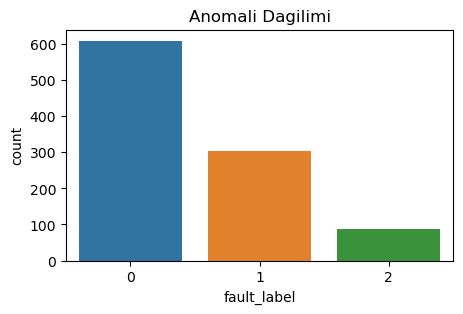

In [43]:
plt.figure(figsize = (5, 3)) 
sns.countplot(x = "fault_label", data = df)
""" sns.countplot
    Bu bir Seaborn fonksiyonu.
    Fault Label sutunundaki her bir kategoriden kac tane oldugunu sayip, cubuk grafik seklinde gosterir. """
plt.title("Anomali Dagilimi")
plt.show()

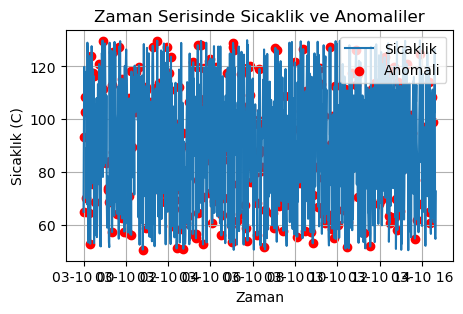

In [ ]:
# Zaman Serisi Gorsellestirme (Örnek: Sicaklik)
plt.figure(figsize = (5, 3))
plt.plot(df["timestamp"], df["temperature_c"], label = "Sicaklik")
""" x-ekseni Zaman (Timestamp)
    y-ekseni Sicaklik (Temperature (°C)) """

plt.scatter(df[df["fault_label"] == 1]["timestamp"],
            df[df["fault_label"] == 1]["temperature_c"], 
            color = 'red', label = "Anomali")

# Anomalilerin oldugu yerleri kirmizi ile isaretliyor.

plt.xlabel("Zaman")
plt.ylabel("Sicaklık (C)")
plt.title("Zaman Serisinde Sicaklik ve Anomaliler")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
df.drop(columns=['mean_temperature', 'rms_vibration'], inplace=True)

In [46]:
df

,timestamp,vibration_mm_s,temperature_c,pressure_bar,fault_label
0,2023-03-10 00:00:00,0.437086,64.810634,7.785117,1
1,2023-03-10 00:01:00,0.955643,93.352076,7.740936,1
2,2023-03-10 00:02:00,0.758795,119.835667,9.718764,0
3,2023-03-10 00:03:00,0.638793,108.577991,7.748639,1
4,2023-03-10 00:04:00,0.240417,114.524892,7.815849,0
...,...,...,...,...,...
995,2023-03-10 16:35:00,0.182424,102.556413,9.595887,0
996,2023-03-10 16:36:00,0.925582,126.529170,7.471820,0
997,2023-03-10 16:37:00,0.223137,55.516641,7.929364,0
998,2023-03-10 16:38:00,0.955214,54.564378,7.870137,0


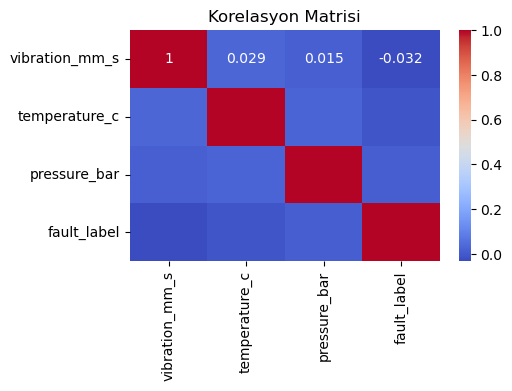

In [47]:
# Korelasyon Matrisi
plt.figure(figsize = (5, 3))
sns.heatmap(df.drop(columns = ['timestamp']).corr(), annot = True, cmap = "coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

In [48]:
# FEATURE ENGINEERING

# Sıcaklık ve Basınç Oranı
df['temp_press_ratio'] = df['temperature_c'] / (df['pressure_bar'] + 1e-6)

# Titreşim ve Sıcaklık Oranı
df['vib_temp_ratio'] = df['vibration_mm_s'] / (df['temperature_c'] + 1e-6)

# Sıcaklık Ile Ortalama Sıcaklık Farkı
if 'mean_temperature' in df.columns:
    df['temp_mean_diff'] = df['temperature_c'] - df['mean_temperature']

# Titreşim Ile RMS Titreşim Farkı
if 'rms_vibration' in df.columns:
    df['vib_rms_diff'] = df['vibration_mm_s'] - df['rms_vibration']

""" Bu yeni sutunlar, ozellikler, modelin daha iyi ogrenmesini saglar cunku bazen iki degiskenin orani, mutlak degerlerinden
daha anlamli bir sinyal tasir.
Ani sapmalari, dengesizlikleri daha net ortaya koyar.
Anomali tespiti icin normalden sapma çok kritiktir. """

' Bu yeni sutunlar, ozellikler, modelin daha iyi ogrenmesini saglar cunku bazen iki degiskenin orani, mutlak degerlerinden\ndaha anlamli bir sinyal tasir.\nAni sapmalari, dengesizlikleri daha net ortaya koyar.\nAnomali tespiti icin normalden sapma çok kritiktir. '

In [ ]:
# Istatiksel Standartlastirma (z-Score Normalization): Anomali bulmada kullanilir.
for col in ['temperature_c', 'pressure_bar', 'vibration_mm_s']: # Bu sutunlar icin;
    mean = df[col].mean() # Ortalama hesapliyor, 
    std = df[col].std() # Standart sapma hesapliyor.
    df[f'{col}_zscore'] = (df[col] - mean) / std

    # z-score sayesinde her degerin ortalamasindan kac standart sapma uzaklikta oldugunu gorebiliriz.

KeyError: 'vibration_mm_s)'

In [ ]:
""" Hareketli Ortalama (MA):
    Zaman serisindeki gurultuyu azaltir.
    Daha duzgun bir trend cizgisi verir.
    Ozellikle anomali tespitinde, anomali hareketli ortalamadan çok sapiyorsa daha belirgin hale gelir. 
    
    Fark Alma (Diff):
    Ani degisimleri, yani zaman icindeki hizlanmalari, sicramalari gosterir.
    Ariza, anomali genelde bir anda artan titresim ya da sicaklik ile ortaya cikar."""

window = 5 # Rolling islemleri son 5 gozlem ile yapilacak.
df['temperature_c_ma'] = df['temperature_c'].rolling(window).mean()
df['temperature_c_diff'] = df['temperature_c'].diff()
df['vibration_mm_s)_ma'] = df['vibration_mm_s'].rolling(window).mean()
df['vibration_mm_s_diff'] = df['vibration_mm_s'].diff()

In [ ]:
# Feature Engineering
df['temp_plus_vib'] = df['temperature_c'] + df['vibration_mm_s'] # Sicaklik + Titresim
# Bu toplam deger, bu iki degiskenin birlikte anormal artisini daha kolay yakalar.

df['press_times_vib'] = df['pressure_bar'] * df['vibration_mm_s'] # Basinc * Titresim
# Carpim, ozellikle iki degisken ayni anda yuksek olunca cok daha hizli buyur.

In [ ]:
df['log_temperature_c'] = np.log1p(df['temperature_c'])
df['log_vibration_mm_s'] = np.log1p(df['vibration_mm_s'])

In [ ]:
df

,Timestamp,Vibration (mm/s),Temperature (°C),Pressure (bar),Fault Label,temp_press_ratio,vib_temp_ratio,Temperature (°C)_zscore,Pressure (bar)_zscore,Vibration (mm/s)_zscore,Temperature (°C)_ma,Temperature (°C)_diff,Vibration (mm/s)_ma,Vibration (mm/s)_diff,temp_plus_vib,press_times_vib
0,2023-03-10 00:00:00,0.437086,64.810634,7.785117,1,8.324939,0.006744,-1.101627,-0.828075,-0.396103,NaN,NaN,NaN,NaN,65.247720,3.402767
1,2023-03-10 00:01:00,0.955643,93.352076,7.740936,1,12.059531,0.010237,0.119387,-0.878740,1.576169,NaN,28.541441,NaN,0.518557,94.307719,7.397571
2,2023-03-10 00:02:00,0.758795,119.835667,9.718764,0,12.330339,0.006332,1.252365,1.389352,0.827479,NaN,26.483591,NaN,-0.196848,120.594461,7.374545
3,2023-03-10 00:03:00,0.638793,108.577991,7.748639,1,14.012523,0.005883,0.770758,-0.869907,0.371065,NaN,-11.257676,NaN,-0.120002,109.216784,4.949773
4,2023-03-10 00:04:00,0.240417,114.524892,7.815849,0,14.652903,0.002099,1.025168,-0.792833,-1.144112,100.220252,5.946901,0.606147,-0.398376,114.765309,1.879061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-03-10 16:35:00,0.182424,102.556413,9.595887,0,10.687537,0.001779,0.513152,1.248443,-1.364682,87.005082,-7.553594,0.461733,-0.242453,102.738836,1.750519
996,2023-03-10 16:36:00,0.925582,126.529170,7.471820,0,16.934182,0.007315,1.538716,-1.187352,1.461836,99.768386,23.972757,0.501804,0.743158,127.454752,6.915783
997,2023-03-10 16:37:00,0.223137,55.516641,7.929364,0,7.001399,0.004019,-1.499228,-0.662659,-1.209835,91.108111,-71.012528,0.477445,-0.702445,55.739778,1.769333
998,2023-03-10 16:38:00,0.955214,54.564378,7.870137,0,6.933091,0.017506,-1.539966,-0.730578,1.574536,89.855322,-0.952264,0.542247,0.732077,55.519591,7.517662


In [ ]:
# Random Forest
features = [
    'temperature_c', 'vibration_mm_s', 'pressure_bar',
    'temp_press_ratio', 'vib_temp_ratio',
    'temp_mean_diff', 'vib_rms_diff',
    'temperature_c_zscore', 'pressure_bar_zscore', 'vibration_mm_s_zscore',
    'temperature_c_ma', 'temperature_c_diff', 'vibration_mm_s_ma', 'vibration_mm_s_diff',
    'temp_plus_vib', 'press_times_vib',
    'log_temperature_c', 'log_vibration_mm_s'
]

In [ ]:
features = [col for col in features if col in df.columns]
X = df[features]
y = df['Fault Label']
y = y.apply(lambda x: 0 if x == 0 else 1)  # 0: Normal, 1: Anomali

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

NameError: name 'y_pred' is not defined